# **Project Title: Study on relationship between histology image features and model missclassifications using XAI Techniques.**

In [ ]:
!apt-get install -y openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 29 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (86.0 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extracting the WSI slides into small tiles with applying region of interest (ROI) as annotations. And seperated the tiles as sets of trian, val and test for further to run the DL models

In [ ]:
import openslide
from PIL import Image
import xml.etree.ElementTree as ET
import os
import random

# Paths for class_a and class_b
class_paths = {
    "class_a": "/content/drive/MyDrive/class_a",
    "class_b": "/content/drive/MyDrive/class_b"
}

# Tile settings
tile_size = 512
step_size = 512
split_ratios = {"train": 0.7, "val": 0.2, "test": 0.1}

# Helper function to check if tiles intersect annotations
def does_tile_intersect_annotations(x, y, tile_size, annotations):
    tile_box = (x, y, x + tile_size, y + tile_size)
    for annotation in annotations:
        for px, py in annotation:
            if tile_box[0] <= px < tile_box[2] and tile_box[1] <= py < tile_box[3]:
                return True
    return False

# Process each class folder independently
for cls, cls_path in class_paths.items():
    print(f"Processing {cls}...")

    wsi_dir = os.path.join(cls_path, "wsi_images")
    annotation_dir = os.path.join(cls_path, "annotations")
    output_dir = os.path.join(cls_path, "extracted_tiles")

    # Ensure output directories for train/val/test
    split_dirs = {}
    for split in split_ratios:
        split_dirs[split] = os.path.join(output_dir, split)
        os.makedirs(split_dirs[split], exist_ok=True)

    # Process each WSI and its corresponding annotation
    for wsi_filename in os.listdir(wsi_dir):
        if wsi_filename.endswith('.svs'):
            wsi_path = os.path.join(wsi_dir, wsi_filename)
            annotation_path = os.path.join(annotation_dir, wsi_filename.replace('.svs', '.xml'))

            # Open the WSI
            slide = openslide.OpenSlide(wsi_path)
            dimensions = slide.dimensions
            print(f"Processing {wsi_filename}: Dimensions {dimensions}")

            # Parse the annotation XML file
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            # Extract annotation regions
            annotations = []
            for region in root.findall(".//Region"):
                vertices = region.find("Vertices")
                points = [(int(float(vertex.attrib["X"])), int(float(vertex.attrib["Y"])))
                          for vertex in vertices.findall("Vertex")]
                annotations.append(points)

            # Extract tiles
            valid_tiles = []
            for x in range(0, dimensions[0], step_size):
                for y in range(0, dimensions[1], step_size):
                    if does_tile_intersect_annotations(x, y, tile_size, annotations):
                        tile = slide.read_region((x, y), 0, (tile_size, tile_size)).convert("RGB")
                        valid_tiles.append(tile)

            # Shuffle and split tiles into train/val/test
            random.shuffle(valid_tiles)
            num_tiles = len(valid_tiles)
            train_split = int(split_ratios["train"] * num_tiles)
            val_split = int(split_ratios["val"] * num_tiles)

            splits = {
                "train": valid_tiles[:train_split],
                "val": valid_tiles[train_split:train_split + val_split],
                "test": valid_tiles[train_split + val_split:]
            }

            # Save tiles into respective folders
            wsi_basename = os.path.splitext(wsi_filename)[0]
            for split, tiles in splits.items():
                for i, tile in enumerate(tiles):
                    tile_filename = os.path.join(split_dirs[split], f"{wsi_basename}_tile_{i}.png")
                    tile.save(tile_filename)

            # Print summary
            for split, tiles in splits.items():
                print(f"Extracted {len(tiles)} tiles for {split} from {wsi_filename}.")

    print(f"Finished processing {cls}. Tiles saved in {output_dir}")

Processing class_a...
Finished processing class_a. Tiles saved in /content/drive/MyDrive/class_a/extracted_tiles
Processing class_b...
Processing cervix_032.svs: Dimensions (120033, 83698)
Extracted 148 tiles for train from cervix_032.svs.
Extracted 42 tiles for val from cervix_032.svs.
Extracted 22 tiles for test from cervix_032.svs.
Processing cervix_004.svs: Dimensions (112772, 87172)
Extracted 345 tiles for train from cervix_004.svs.
Extracted 98 tiles for val from cervix_004.svs.
Extracted 51 tiles for test from cervix_004.svs.
Processing cervix_009.svs: Dimensions (99753, 87741)
Extracted 153 tiles for train from cervix_009.svs.
Extracted 43 tiles for val from cervix_009.svs.
Extracted 23 tiles for test from cervix_009.svs.
Finished processing class_b. Tiles saved in /content/drive/MyDrive/class_b/extracted_tiles


# Calculating the avaerage darkness values of the train dataset to see how the darkness variance existed between classes

In [ ]:
import os
from PIL import Image
import numpy as np
import csv

# Path to the directory containing class_a and class_b folders
base_dir = "/content/drive/MyDrive/train"

# Output CSV file
output_file = "/content/drive/MyDrive/average_darkness.csv"

# Function to calculate average darkness
def calculate_darkness(image_path):
    """
    Calculate the average darkness of a given image.
    :param image_path: Path to the PNG image
    :return: average_darkness
    """
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    avg_darkness = 255 - np.mean(image_array)
    return avg_darkness

# Create list to store results
results = []

# Process each class separately
for class_name in ["class_a", "class_b"]:
    class_path = os.path.join(base_dir, class_name)

    if not os.path.exists(class_path):
        print(f"Skipping {class_name}, folder not found.")
        continue

    # Process all PNG files in the class directory
    for image_name in os.listdir(class_path):
        if image_name.endswith('.png'):
            image_path = os.path.join(class_path, image_name)
            avg_darkness = calculate_darkness(image_path)
            results.append([class_name, image_name, avg_darkness])

# Save results to CSV file
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Class", "Image Name", "Average Darkness"])
    writer.writerows(results)

print(f"Results saved to: {output_file}")


Results saved to: /content/drive/MyDrive/average_darkness.csv


To understand values of average darkness either the above code runs well or not

In [ ]:
import pandas as pd
import random

# Path to the CSV file containing average darkness values
csv_file = "/content/drive/MyDrive/average_darkness.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_file)

# Randomly select 5 rows
random_images = data.sample(n=min(5, len(data)))

# Print the random rows
print("\nSample of 5 Random Images:")
print("Image Name, Average Darkness")
for _, row in random_images.iterrows():
    print(f"{row['Image Name']}, {row['Average Darkness']:.2f}")


Sample of 5 Random Images:
Image Name, Average Darkness
cervix_045_tile_251.png, 75.10
cervix_048_tile_4.png, 78.35
cervix_007_tile_834.png, 25.59
cervix_032_tile_37.png, 10.99
cervix_032_tile_109.png, 28.23


# Performed statistical analysis with darkness values to see the variance between classes with one way ANOVA

ANOVA for Darkness (Class A vs. Class B) - F-statistic: 832.48, P-value: 0.00000


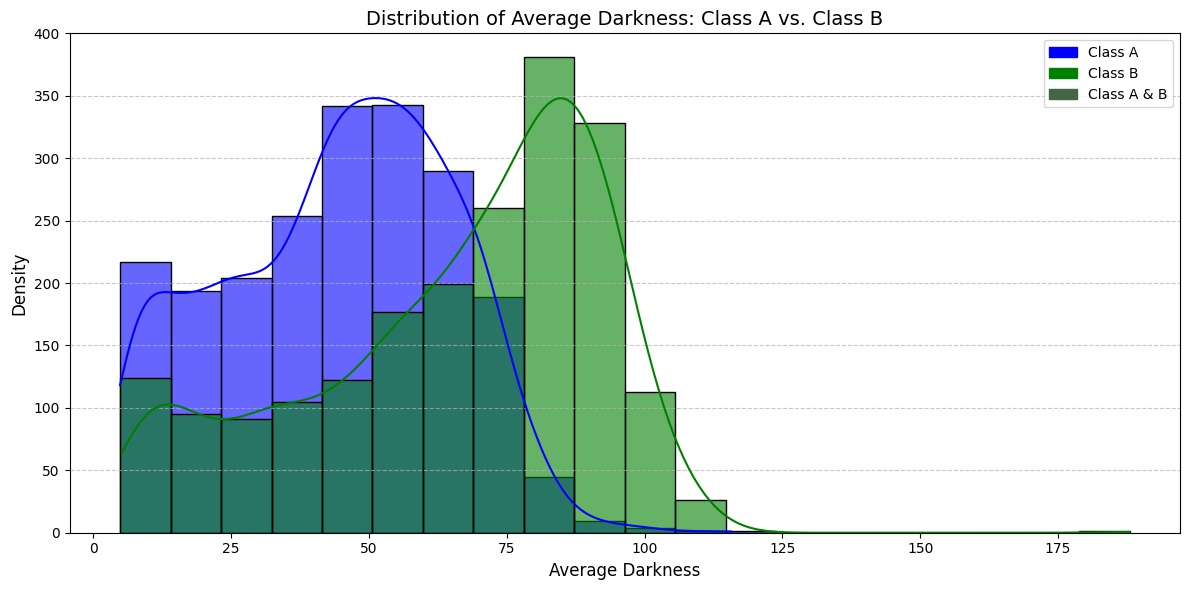

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Load the updated CSV file
csv_path = "/content/drive/MyDrive/average_darkness.csv"
df = pd.read_csv(csv_path)

# Separate the classes
class_a = df[df["Class"] == "class_a"]["Average Darkness"]
class_b = df[df["Class"] == "class_b"]["Average Darkness"]

# Perform ANOVA for Darkness in Class A vs. Class B
stat_darkness, p_value_darkness = f_oneway(class_a, class_b)
print(f"ANOVA for Darkness (Class A vs. Class B) - F-statistic: {stat_darkness:.2f}, P-value: {p_value_darkness:.5f}")

# Define the bins for the histogram
bins = np.histogram_bin_edges(np.concatenate((class_a, class_b)), bins=20)

# Plot Darkness Distributions
plt.figure(figsize=(12, 6))

# Histogram for Class A
sns.histplot(class_a, bins=bins, kde=True, color="blue", label="Class A", alpha=0.6)

# Histogram for Class B
sns.histplot(class_b, bins=bins, kde=True, color="green", label="Class B", alpha=0.6)

# Create a mixed color (blend of blue and green)
blended_color = "#446644"

# Create a legend entry for the overlapping region
overlap_patch = mpatches.Patch(color=blended_color, label="Class A & B")

# Labels and title
plt.title("Distribution of Average Darkness: Class A vs. Class B", fontsize=14)
plt.xlabel("Average Darkness", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Set the legend on the right with Class A, Class B, and Overlapping Region
plt.legend(handles=[
    mpatches.Patch(color="blue", label="Class A"),
    mpatches.Patch(color="green", label="Class B"),
    overlap_patch
], loc="upper right")

# Grid for better visualization
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Augmenting the images with 90,180 and 270 degrees randomly for the model generalization and to increase accuracy

In [ ]:
import os
import random
from PIL import Image
from tqdm import tqdm

# Define augmentation functions
def random_rotation(image):
    """Rotate image by 90, 180, or 270 degrees to preserve histology."""
    angle = random.choice([90, 180, 270])
    return image.rotate(angle)

def random_flip(image):
    """Randomly flip image horizontally and/or vertically."""
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    return image

# Define paths
base_dir = "/content/drive/MyDrive"
class_paths = {
    "train_class_a": os.path.join(base_dir, "train", "class_a"),
    "train_class_b": os.path.join(base_dir, "train", "class_b"),
    "val_class_a": os.path.join(base_dir, "val", "class_a"),
    "val_class_b": os.path.join(base_dir, "val", "class_b"),
}

# Augmentation settings
augment_factor = 3

# Apply augmentations to train and val sets
for cls, cls_path in class_paths.items():
    print(f"Processing {cls} augmentation...")

    # Ensure augmented directory exists
    augmented_dir = f"{cls_path}_augmented"
    os.makedirs(augmented_dir, exist_ok=True)

    # Check if directory exists before processing
    if not os.path.exists(cls_path):
        print(f"Skipping {cls}: Directory not found -> {cls_path}")
        continue

    images = [img for img in os.listdir(cls_path) if img.endswith(".png")]

    for img_name in tqdm(images, desc=f"Augmenting images for {cls}"):
        img_path = os.path.join(cls_path, img_name)
        image = Image.open(img_path)

        # Save original image in the augmented dataset as well
        image.save(os.path.join(augmented_dir, img_name))

        # Generate augmentations
        for i in range(augment_factor):
            augmented_img = image.copy()
            augmented_img = random_rotation(augmented_img)
            augmented_img = random_flip(augmented_img)

            # Save augmented image
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i}.png"
            aug_img_path = os.path.join(augmented_dir, aug_img_name)
            augmented_img.save(aug_img_path)

    print(f"Finished augmenting {cls}. Augmented images saved in {augmented_dir}")

print(" Data augmentation completed successfully!")


Processing train_class_a augmentation...


Augmenting images for train_class_a: 100%|██████████| 2093/2093 [15:15<00:00,  2.29it/s]


Finished augmenting train_class_a. Augmented images saved in /content/drive/MyDrive/train/class_a_augmented
Processing train_class_b augmentation...


Augmenting images for train_class_b: 100%|██████████| 2022/2022 [14:19<00:00,  2.35it/s]


Finished augmenting train_class_b. Augmented images saved in /content/drive/MyDrive/train/class_b_augmented
Processing val_class_a augmentation...


Augmenting images for val_class_a: 100%|██████████| 596/596 [04:23<00:00,  2.26it/s]


Finished augmenting val_class_a. Augmented images saved in /content/drive/MyDrive/val/class_a_augmented
Processing val_class_b augmentation...


Augmenting images for val_class_b: 100%|██████████| 571/571 [04:01<00:00,  2.36it/s]

Finished augmenting val_class_b. Augmented images saved in /content/drive/MyDrive/val/class_b_augmented
✅ Data augmentation completed successfully!


Just checking the dataset images with sub folders before running the model

In [ ]:
import os

# Define dataset paths
dataset_dirs = {
    "train": "/content/drive/MyDrive/train",
    "val": "/content/drive/MyDrive/val",
    "test": "/content/drive/MyDrive/test"
}

# Function to count images in each class
def count_images(dataset_path):
    counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))])
    return counts

# Count images in train, val, test
for dataset, path in dataset_dirs.items():
    if os.path.exists(path):
        class_counts = count_images(path)
        print(f"\n {dataset.upper()} Set:")
        for class_name, count in class_counts.items():
            print(f"  🔹 {class_name}: {count} images")
    else:
        print(f"\n Warning: {dataset} directory not found at {path}")


📌 TRAIN Set:
  🔹 class_b: 8088 images
  🔹 class_a: 8372 images

📌 VAL Set:
  🔹 class_a: 2384 images
  🔹 class_b: 2284 images

📌 TEST Set:
  🔹 class_b: 307 images
  🔹 class_a: 307 images


In [ ]:
!nvidia-smi

Wed Feb 19 18:56:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             53W /  400W |    2529MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EfficientnetB0 base model training with using A100 GPU and High RAM from colab

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import os
import shutil

# Disable Mixed Precision (use float32 everywhere)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

# Copy dataset from Google Drive to Colab RAM (Faster than streaming)
os.makedirs('/content/dataset', exist_ok=True)
if not os.path.exists('/content/dataset/train'):
    print("Copying dataset to Colab RAM...")
    shutil.copytree('/content/drive/MyDrive/train', '/content/dataset/train')
    shutil.copytree('/content/drive/MyDrive/val', '/content/dataset/val')
    shutil.copytree('/content/drive/MyDrive/test', '/content/dataset/test')

# Define dataset directories
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'
test_dir = '/content/dataset/test'

# Define image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

# Load dataset using `tf.data`
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
class_names = raw_train_dataset.class_names

# Define Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

# Define normalization layer
normalization_layer = Normalization()

# Function to convert images to float32
def cast_to_float32(image, label):
    return tf.cast(image, tf.float32), label

# Function to apply augmentation + normalization
def preprocess_image(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

# Convert dataset images to float32 before applying normalization
normalized_train_dataset = raw_train_dataset.map(cast_to_float32)

# Adapt Normalization Layer using training data (only on images)
normalization_layer.adapt(normalized_train_dataset.map(lambda x, y: x))

# Apply augmentation & normalization to dataset
train_dataset = normalized_train_dataset.map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
).map(cast_to_float32).map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
).map(cast_to_float32).map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

# Load Pre-trained EfficientNetB0 with Correct Input Shape
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Custom Classification Layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.005))(x)  # L2 Regularization Increased
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  # Dropout Increased
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.6)(x)

# Use `len(class_names)`
outputs = Dense(len(class_names), activation='softmax')(x)

# Define the Model
model = Model(inputs=base_model.input, outputs=outputs)

# Freeze the First 120 Layers (EfficientNetB0 has ~236 layers)
for layer in base_model.layers[:120]:
    layer.trainable = False

# Compile Model with Optimized Learning Rate
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if validation loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1,
    callbacks=[early_stopping]
)

# Unfreeze More Layers & Fine-tune
for layer in base_model.layers[80:]:
    layer.trainable = True

# **Implement Learning Rate Decay**
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=1000,
    decay_rate=0.95
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile Again with Learning Rate Decay
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_accuracy:.2f}")

# Save Model
model.save('/content/drive/MyDrive/saved_models/efficientnet_model2.keras')


Copying dataset to Colab RAM...
Found 16460 files belonging to 2 classes.
Found 4668 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.6948 - loss: 7.7964 - val_accuracy: 0.5970 - val_loss: 4.9915
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8498 - loss: 3.7934 - val_accuracy: 0.7001 - val_loss: 2.6096
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8896 - loss: 1.8908 - val_accuracy: 0.8843 - val_loss: 1.3151
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9041 - loss: 1.1665 - val_accuracy: 0.8832 - val_loss: 1.0002
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9228 - loss: 0.8429 - val_accuracy: 0.9012 - val_loss: 0.7486
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9282 - loss: 0.6486 - val_accuracy: 0.9192 - val_loss: 0.5590
Epoch 7/15
129/129 ━

# Resnet50 base model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import os
import shutil

# Disable Mixed Precision (use float32 everywhere)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

# Copy dataset from Google Drive to Colab RAM (Faster than streaming)
os.makedirs('/content/dataset', exist_ok=True)
if not os.path.exists('/content/dataset/train'):
    print("Copying dataset to Colab RAM...")
    shutil.copytree('/content/drive/MyDrive/train', '/content/dataset/train')
    shutil.copytree('/content/drive/MyDrive/val', '/content/dataset/val')
    shutil.copytree('/content/drive/MyDrive/test', '/content/dataset/test')

# Define dataset directories
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'
test_dir = '/content/dataset/test'

# Define image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

# Load dataset using `tf.data`
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
class_names = raw_train_dataset.class_names

# Define Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

# Define normalization layer
normalization_layer = Normalization()

# Function to convert images to float32
def cast_to_float32(image, label):
    return tf.cast(image, tf.float32), label

# Function to apply augmentation + normalization
def preprocess_image(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

# Convert dataset images to float32 before applying normalization
normalized_train_dataset = raw_train_dataset.map(cast_to_float32)

# Adapt Normalization Layer using training data (only on images)
normalization_layer.adapt(normalized_train_dataset.map(lambda x, y: x))

# Apply augmentation & normalization to dataset
train_dataset = normalized_train_dataset.map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
).map(cast_to_float32).map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
).map(cast_to_float32).map(preprocess_image).prefetch(buffer_size=AUTOTUNE)

# Load Pre-trained ResNet50 with Correct Input Shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Custom Classification Layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  # Dropout Increased
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
x = Dropout(0.6)(x)

# Use `len(class_names)`
outputs = Dense(len(class_names), activation='softmax')(x)

# Define the Model
model = Model(inputs=base_model.input, outputs=outputs)

# Freeze the First 120 Layers (ResNet50 has ~175 layers)
for layer in base_model.layers[:120]:
    layer.trainable = False

# Compile Model with Optimized Learning Rate
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1,
    callbacks=[early_stopping]
)

# Unfreeze More Layers & Fine-tune
for layer in base_model.layers[80:]:
    layer.trainable = True

# **Implement Learning Rate Decay**
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=1000,
    decay_rate=0.95
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile Again with Learning Rate Decay
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_accuracy:.2f}")

# Save Model
model.save('/content/drive/MyDrive/saved_models/resnet_model2.keras')


Copying dataset to Colab RAM...
Found 16460 files belonging to 2 classes.
Found 4668 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7407 - loss: 6.9976 - val_accuracy: 0.6352 - val_loss: 4.2183
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8283 - loss: 2.6677 - val_accuracy: 0.7890 - val_loss: 1.7422
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8776 - loss: 1.3120 - val_accuracy: 0.7830 - val_loss: 1.2078
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8857 - loss: 0.9056 - val_accuracy: 0.8625 - val_loss: 0.7709
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9036 - loss: 0.6338 - val_accuracy: 0.8398 - val_loss: 0.6504
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9114 - loss: 0.4852 - val_accuracy: 0.7967 - val_loss: 0.7582
Epoch 7/15
129/129 ━

# Using XAI method of Grad-CAM applying on resnent50

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
ResNet Prediction: Class A (0.52)
Actual Class: Class B


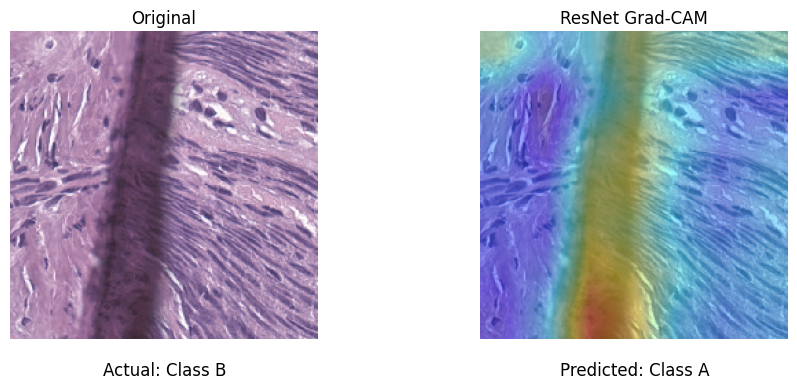

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Load ResNet model
resnet_model_path = "/content/drive/MyDrive/saved_models/resnet_model2.keras"
resnet_model = tf.keras.models.load_model(resnet_model_path)

# Define class labels
class_labels = ["Class A", "Class B"]
resnet_last_conv = "conv5_block3_out"

# Grad-CAM function
def compute_gradcam(img_array, model, last_conv_layer_name):
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradients are None.")
        return np.zeros((7, 7), dtype=np.float32)

    grads = grads / (tf.math.reduce_max(grads) + tf.keras.backend.epsilon())
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    return heatmap

# Overlay function
def overlay_gradcam(image_path, model, last_conv_layer_name, true_label, pred_label):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    heatmap = compute_gradcam(img_array_expanded, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.array(img, dtype=np.uint8)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return img, overlay

# Image path
image_path = "/content/drive/MyDrive/test/class_b/cervix_014_tile_16.png"

# Prediction
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0
resnet_pred_probs = resnet_model.predict(img_array)[0]
resnet_pred_idx = np.argmax(resnet_pred_probs)
resnet_pred = class_labels[resnet_pred_idx]
actual_class = "Class A" if "class_a" in image_path else "Class B"

# Output
print(f"ResNet Prediction: {resnet_pred} ({resnet_pred_probs[resnet_pred_idx]:.2f})")
print(f"Actual Class: {actual_class}")

# Grad-CAM overlay
original_img, overlay = overlay_gradcam(image_path, resnet_model, resnet_last_conv, actual_class, resnet_pred)

# Show images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")
plt.text(112, 250, f"Actual: {actual_class}", fontsize=12, ha='center', color='black')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("ResNet Grad-CAM")
plt.axis("off")
plt.text(112, 250, f"Predicted: {resnet_pred}", fontsize=12, ha='center', color='black')

plt.tight_layout()
plt.show()


# Using XAI method of Grad-CAM applying on efficientnetB0

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
EfficientNet Prediction: Class A (0.61)
Actual Class: Class B


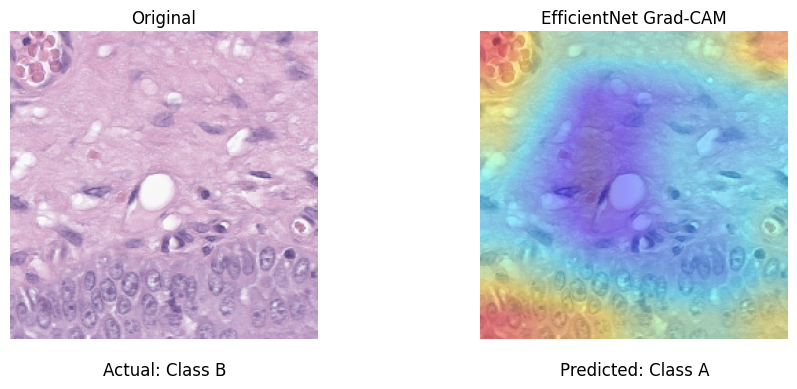

In [2]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Load EfficientNet model
efficientnet_model_path = "/content/drive/MyDrive/saved_models/efficientnet_model5.keras"
efficientnet_model = tf.keras.models.load_model(efficientnet_model_path)

# Define class labels
class_labels = ["Class A", "Class B"]
efficientnet_last_conv = "top_conv"

# Grad-CAM function
def compute_gradcam(img_array, model, last_conv_layer_name):
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradients are None.")
        return np.zeros((7, 7), dtype=np.float32)

    grads = grads / (tf.math.reduce_max(grads) + tf.keras.backend.epsilon())
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    return heatmap

# Overlay function
def overlay_gradcam(image_path, model, last_conv_layer_name, true_label, pred_label):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    heatmap = compute_gradcam(img_array_expanded, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.array(img, dtype=np.uint8)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return img, overlay

# Image path
image_path = "/content/drive/MyDrive/test/class_b/cervix_133_tile_16.png"


# Prediction
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0
efficientnet_pred_probs = efficientnet_model.predict(img_array)[0]
efficientnet_pred_idx = np.argmax(efficientnet_pred_probs)
efficientnet_pred = class_labels[efficientnet_pred_idx]
actual_class = "Class A" if "class_a" in image_path else "Class B"

# Output
print(f"EfficientNet Prediction: {efficientnet_pred} ({efficientnet_pred_probs[efficientnet_pred_idx]:.2f})")
print(f"Actual Class: {actual_class}")

# Grad-CAM overlay
original_img, overlay = overlay_gradcam(image_path, efficientnet_model, efficientnet_last_conv, actual_class, efficientnet_pred)

# Show images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")
plt.text(112, 250, f"Actual: {actual_class}", fontsize=12, ha='center', color='black')


plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("EfficientNet Grad-CAM")
plt.axis("off")
plt.text(112, 250, f"Predicted: {efficientnet_pred}", fontsize=12, ha='center', color='black')

plt.tight_layout()
plt.show()
